# Lesson 8 - Neural Networks

## Author - Lukas Fiorio

## Instructions

- Read data. Split into train/validate/test. Pre-process.
- Develop a multi-layer neural network
- Try various hyper parameters (learning rate, epochs, layer depth, layer size)
- Evaluate Accuracy (recall, precision, F1)
- Summarize findings

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from matplotlib.ticker import MaxNLocator # integer tick labels

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
# set package options
pd.set_option('display.max_columns', None) # show all columns

### Load data

- From inspection, we note that the first row of the csv contains headers.

In [3]:
# read file into df
file = "https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/RedWhiteWine.csv"
wine_df = pd.read_csv(file, header = 0)

Based on a preview of the data (and from the provided pdf), we see all features are numeric. We confirm this with `.info()` just below, as well.

The target is `Class`, which takes two values. `1` for red wine; `0` for white wine.

In [4]:
wine_df.head() # preview data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Class
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


We get confirmation here of all numeric columns and no missing values.

In [5]:
wine_df.info() # examine data structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  Class                 6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


Before splitting the data into train-test, let's clean up the column names by replacing spaces (` `) with underscores (`_`) and converting to lower case.

In [6]:
wine_df.columns = wine_df.columns.str.replace(' ', '_').str.lower()

### Split the data

Before doing any further preprocessing, let's split our data (columns) into features (`X`) and target (`y`). From there, we'll split (observations) into train-validate-test.

In [7]:
# specify target
target = 'class'

# copy df features and drop target
X = wine_df.copy().drop([target], axis = 1)

# store target separately
y = wine_df[target].copy()

Now let's split the data into train-validate-test sets (80-10-10).  Create a validation set for evaluation of hyper parameters.

- First split into train-test @ 90-10.
- Then split train into train-valid @ 80-10 *(0.90 * (1/9) = 0.1)*

In [8]:
# set the random state
random_state = 0

In [9]:
# split into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = random_state)

# split train into train-validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = (1/9), random_state = random_state)

Reset index on each of our datasets to avoid issues with joining later on (during pre-processing)

In [10]:
# reset index to avoid issues with joining later on
X_train = X_train.reset_index(drop = True)
X_valid = X_valid.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

y_train = y_train.reset_index(drop = True)
y_valid = y_valid.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

Check the # of observations in each datset. Indeed, we've gotten an 80-10-10 split.

In [11]:
# verify size of train/valid/test splits
print(len(X_train), '- # obs: training')
print(len(X_valid), ' - # obs: validation')
print(len(X_test), ' - # obs: test')

5197 - # obs: training
650  - # obs: validation
650  - # obs: test


### Preprocessing

In this section, we'll standardize our continuous columns.  It's important that we did our train-validate-test split *before* this pre-processing so that we can fit our encoders/standardizers on the **training** data.

If we wait to split until *after* we've encoded/standardized our data, then the test data has leaked into our training set (it partially influences the distribution).

Before standardizing all columns, let's quickly check to make sure our columns are indeed continuous and not binary or categorical (in spite of being numeric).

The below cells counts the number of unique values in each feature and display those counts in a bar plot.

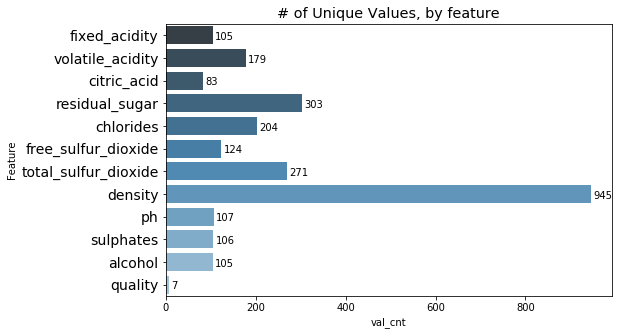

In [12]:
# extract unique value counts of each feature
nunique_df = pd.DataFrame(X_train.nunique().tolist(), index = X_train.columns, columns = ['val_cnt'])

# index contains series values
y_labels = nunique_df.index

# set fig axis properies
fig, ax = plt.subplots(figsize=(8, 5))
ax.title.set_text('# of Unique Values, by feature');
ax.title.set_size('x-large');
ax.set(xlabel='# unique values', ylabel='Feature');
ax.set_yticklabels(y_labels, fontsize=14);

# plot chart
graph = sns.barplot(x=nunique_df['val_cnt'], y=y_labels, palette="Blues_d", ax = ax);

# add value labels
for p in graph.patches:
    _x = p.get_x() + p.get_width() + float(5)
    _y = p.get_y() + p.get_height() - float(0.2)
    value = int(p.get_width())
    ax.text(_x, _y, value, ha="left")

From the above chart we see that all of these are indeed continuous.  `quality` could be considered categorical, with 7 unique values, but they are ordinal and we will treat them as numeric to start.

This decision could be something to revisit if model performance is not adequate.

In [13]:
X_train['quality'].value_counts().sort_index()

3      21
4     176
5    1726
6    2258
7     861
8     150
9       5
Name: quality, dtype: int64

#### Standardizing continous columns

We've verified that our features are continuous and now we should scale the data. *Technically*, our neural network shouldn't suffer even if we leave unstandardized, however we want our features and weights to be centered around 0 to help it converge more quickly (especially true if we use the sigmoid activation function).

We'll fit the `znormalizer` on the training data and then apply it to the validation and test set.  As mentioned above, this is to prevent leakage from the test/validation set into the training set (where we fit our model).

In [14]:
# initialize and fit z-transform based on TRAIN data
znormalizer = StandardScaler()
znormalizer.fit(X_train)

# apply fitted transformation to train, validate, and test data
X_train_featurized = pd.DataFrame(znormalizer.transform(X_train), columns = X_train.columns)
X_valid_featurized = pd.DataFrame(znormalizer.transform(X_valid), columns = X_valid.columns)
X_test_featurized = pd.DataFrame(znormalizer.transform(X_test), columns = X_test.columns)

#### Class imbalance

Checking class imbalance on our train data, we see that our data are definitely biased toward white wine (`target = 0`). Only about 1,300 rows (~25%) have are red wine.

For a neural network, class imbalance may not necessarily be an issue, so we will pass on using oversampling techniques to address it for now.

In [15]:
print("{:.2%}".format((y_train==1).mean()), 'of values')
print(y_train.value_counts())

24.61% of values
0    3918
1    1279
Name: class, dtype: int64


### Explore the training data a bit

Function to loop through and plot distributions, given a df & list of columns.

In [16]:
def dist_plots(df, col_list, n_cols):
    
    # deduce nbr of rows needed for plot
    n_rows = math.ceil(len(col_list) / n_cols)

    # set figure, axis properties
    fig, ax = plt.subplots(ncols = n_cols, nrows = n_rows)
    fig.set_size_inches(16, 4 * n_rows)
    fig.tight_layout(h_pad = 6, w_pad = 12)

    # loop through each column & plot
    for i, col in enumerate(col_list):
        
        # compute row, col index
        i_row = math.floor(i/n_cols)
        i_col = i % n_cols
        
        # make plots
        sns.distplot(a = df[col], ax = ax[i_row][i_col]); # check dist of target (continous)
        ax[i_row][i_col].title.set_text('Distribution of wine ' + col);

For better interpretability, we'll loop through the columns in the *unscaled* training set and visually inspect their distributions.

- Many of our features have long, right tails
- `density` and `ph` appear to be close to normally distributed
- `total_sulfur_dioxide` appears to be bi-modal

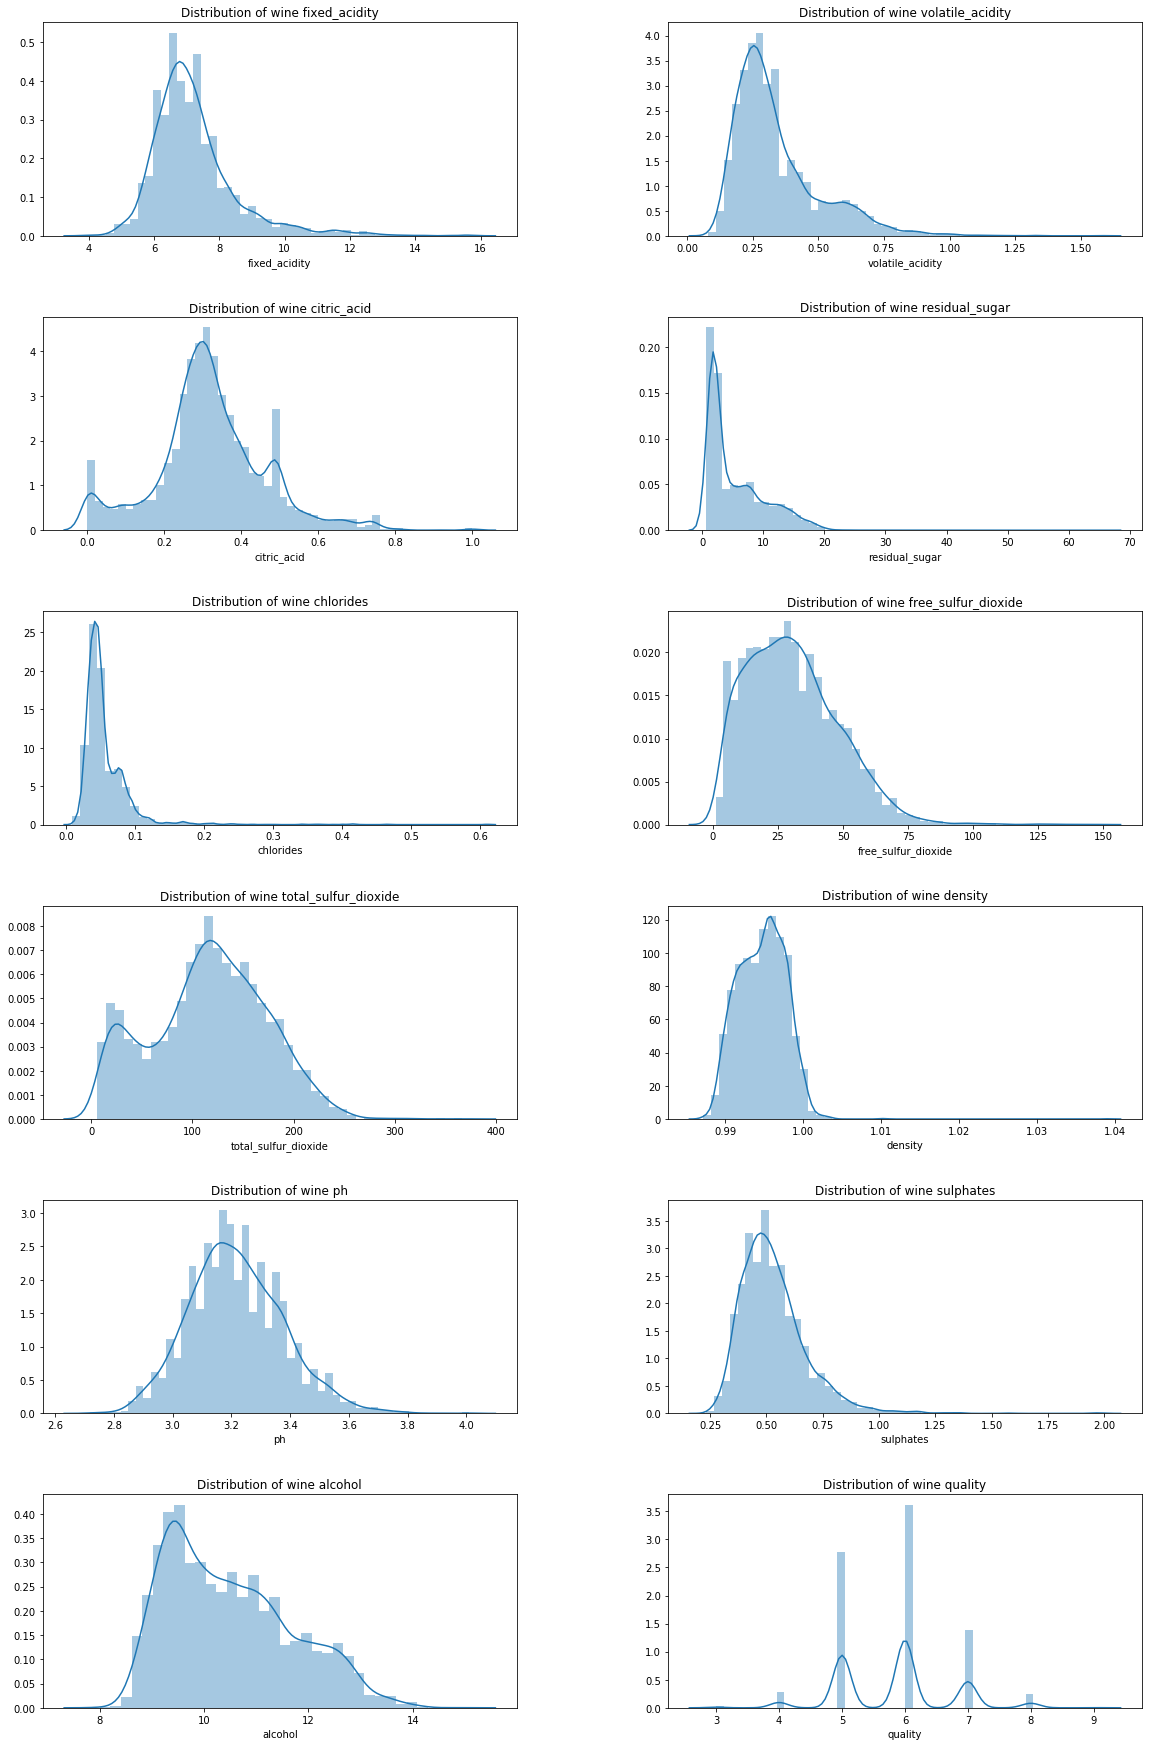

In [17]:
num_cols = X_train.select_dtypes(['float', 'int']).columns.to_list()
dist_plots(X_train, num_cols, 2)

Now let's examine the correlation between each of our features and the target.  For this, we'll use our featurized (standardized) training data.

We'll plot correlation between each feature and the target variable, sorted by absolute value.

- First calculate and sort correlations
- Then Plot tornado chart

We see most of the features have a fairly good level of correlation with the target (0.4 to 0.6), with only `citric_acid`, `quality`, and `alcohol` having less than 0.2 correlation.

In [18]:
# calculate correlations
target_corr = X_train_featurized.apply(lambda x: x.corr(y_train))

# sort series by abs val
target_corr = target_corr.reindex(
    target_corr.abs().sort_values(ascending = False).index
    )

Display plot of correlations.

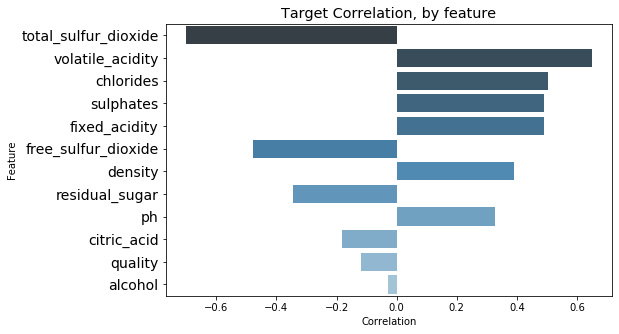

In [19]:
# index contains series values
y_labels = target_corr.index

# set fig axis properies
fig, ax = plt.subplots(figsize=(8, 5))
ax.title.set_text('Target Correlation, by feature');
ax.title.set_size('x-large');
ax.set(xlabel='Correlation', ylabel='Feature');
ax.set_yticklabels(y_labels, fontsize=14);

# plot chart
sns.barplot(x=target_corr, y=y_labels, palette="Blues_d", ax = ax);

Let's also take a look at mutual information, to see whether there's additional usefulness to some of these low correlated features (specifically, `citric_acid`, `quality`, `alcohol`).

First we'll calculate the MI of each feature with the target.

In [20]:
from sklearn.feature_selection import mutual_info_regression
mi_score = mutual_info_regression(X_train_featurized, y_train, random_state=random_state)
mi_score = pd.DataFrame({'attribute': X_train_featurized.columns, 'mi_score': mi_score})

mi_score = pd.DataFrame(mi_score.sort_values(
    by = 'mi_score',
    ascending = False
))

And now let's plot.  It looks like `citric_acid` may have a bit more usefulness than let on by correlation, but `ph` and `quality` may not be that useful to us in our model.

If we decide to apply feature selection at a later point, we may consider dropping those features.

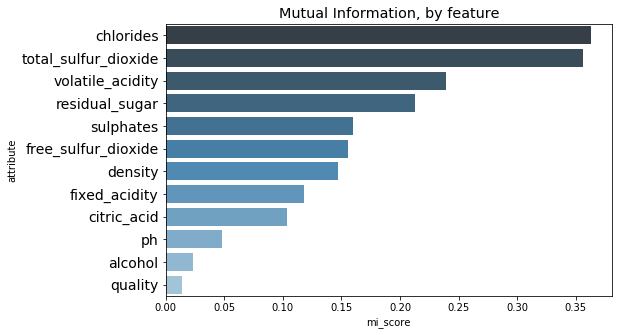

In [21]:
# set fig axis properies
fig, ax = plt.subplots(figsize=(8, 5))
ax.title.set_text('Mutual Information, by feature');
ax.title.set_size('x-large');
ax.set(xlabel='Mutual Information', ylabel='Feature');
ax.set_yticklabels(y_labels, fontsize=14);


# define barplot (sorted descending)
sns.barplot(x='mi_score',
            y='attribute', 
            data = mi_score, 
            order = mi_score['attribute'], 
            palette="Blues_d", 
            ax = ax);

And lastly, let's examine the correlation *between* features.

- `alochol` and `density` features are negatively correlated with each other (`-0.7`)
- the two `sulfer_dioxide` features are positively correlated with each other (`0.7`)
- Most other features have modest (0.3 - 0.5) or low (<0.3) correlation with each other.

Models that require assumptions of independently distributed (IID) features may have *some* issues with these features (as they are).  Our neural network *should* be OK, but could take a bit longer to train and/or have trouble escaping local optimums as a result.  Overall, we should be good to continue on.

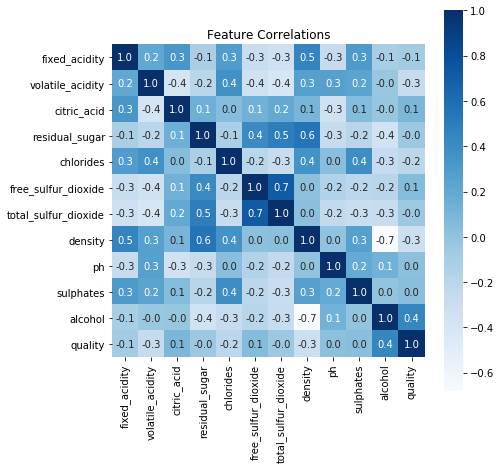

In [22]:
# calc correlations across features
corr = X_train_featurized.corr()

# plot correlations
fig, ax = plt.subplots(figsize=(7, 7));
ax.title.set_text('Feature Correlations');
sns.heatmap(corr, square = True, cmap = 'Blues', fmt = '.1f', ax = ax, annot = True);

## Create a neural network

We want to test out a few different training parameters, so we'll start by defining a function that build an artificial neural network (ANN) for prediction on our binary target (red/white wine).

We pass in data to train and test on, and specify:
- \# of epochs
- batch size
- learning rate
- hidden layers (depth AND size)
- dropout rate (optional)

Between hidden layers, we'll use a ReLU activation function (Rectified Linear Unit. `max(0, x)`).  In our final output layer, we'll use a sigmoid actviation function.

We center our intial weights around 0 (random `~N(0, 1)`) and our bias terms at 0.  Since we've standardized our data, this should be a reasonable starting point.

In [23]:
def ann_binary(X_train, y_train, X_test, y_test, 
               epochs, batch_size, learning_rate, hidden_layers,
               dropout=0, verbose=1):
    '''
    X_train. df: df of features to fit on
    y_train. series: series of binary target values to fit on
    X_test. df: df of features to predict on
    y_test. series: series of binary target values to predict on
    epochs. int: # of training epochs
    batch_size. int: # of observations per training batch
    learning_rate. float: initial learning rate of NN
    hidden_layers. [int]: array of hidden node sizes
    dropout. float: percent of nodes to force-zero in each hidden layer
    verbose. int: whether to display fitting progress (0, 1)
    '''
    
    # clear pre-existing models if needed
    tf.keras.backend.clear_session()
    
    # cnt of features
    n_features = X_train.shape[1]
    
    # initialize model
    model = tf.keras.Sequential()
    
    # Add layers sequentially
    for h_index, h_val in enumerate(hidden_layers):

        # hidden layer 1
        if h_index == 0:
            
            # dense layer, with input dimensions set
            model.add(Dense(
                units = h_val, 
                activation='relu', 
                kernel_initializer='random_normal', 
                input_shape=(n_features,)
            ))

        # hidden layers 2 thru n
        else:
            
            # dense layer, input dimensions inferred
            model.add(Dense(
                units = h_val, 
                activation='relu',
                kernel_initializer='random_normal'
            ))
            
            # if dropout was specified, apply it here
            if (0 < dropout < 1): model.add(Dropout(rate=dropout))

    # add final (output) layer
    model.add(Dense(units = 1, activation='sigmoid'))

    # Setup model with ADAM optimization and cross entropy loss.
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # fit the model and validate against a test set
    model_logs = model.fit(X_train, y_train,
                           epochs=epochs,
                           batch_size=batch_size,
                           validation_data=(X_test, y_test),
                           verbose=verbose
                          )
    
    # return the model itself AND the accuracy logs
    return model, model_logs

And let's define a function to helpful visualize how the neural network is learning over each epoch. We'll also report out how it's final epoch performs on a validation set.

In [24]:
def model_plots(model, test_set="Validation"):

    # cnt of epochs
    epochs = len(model.history['accuracy'])
    final_valid_acc = model.history['val_accuracy'][epochs-1]
    final_valid_loss = model.history['val_loss'][epochs-1]
    
    # set figure, axis properties
    fig, ax = plt.subplots(ncols = 2, nrows = 1)
    fig.set_size_inches(16, 4)
    fig.tight_layout(h_pad = 6, w_pad = 12)

    # make accuracy plot
    sns.lineplot(x = range(1, epochs + 1), y = model.history['accuracy'], ax = ax[0], label = "Train");
    sns.lineplot(x = range(1, epochs + 1), y = model.history['val_accuracy'], ax = ax[0], label = test_set);
    ax[0].title.set_text('Model Accuracy');
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0].legend();
    
    # make loss plot
    sns.lineplot(x = range(1, epochs + 1), y = model.history['loss'], ax = ax[1], label = "Train");
    sns.lineplot(x = range(1, epochs + 1), y = model.history['val_loss'], ax = ax[1], label = test_set);
    ax[1].title.set_text('Model Loss');
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].legend();
    
    # print final stats
    print('\n', test_set, 'Accuracy:', round(final_valid_acc, 3),'\n', test_set, 'Loss:', round(final_valid_loss, 3))

Set seed for replicability.

In [25]:
# set seed for replicability
from numpy.random import seed
seed(random_state)
tf.random.set_seed(random_state)

Now let's try out a few models.

Start with 15 epochs and a small learning rate of 0.005.  We'll have 3 hidden layers (of size 8, 4, 2), with no dropout.

In [26]:
model_1, model_1_logs = ann_binary(X_train = X_train_featurized,
                                   y_train = y_train,
                                   X_test = X_valid_featurized,
                                   y_test = y_valid,
                                   epochs = 15,
                                   batch_size = 256,
                                   learning_rate = 0.005,
                                   hidden_layers = [8, 4, 2]
                                  )

Epoch 1/15
21/21 [==============================] - 0s 8ms/step - loss: 0.6503 - accuracy: 0.7539 - val_loss: 0.5738 - val_accuracy: 0.7477
Epoch 2/15
21/21 [==============================] - 0s 2ms/step - loss: 0.4506 - accuracy: 0.7539 - val_loss: 0.3067 - val_accuracy: 0.7477
Epoch 3/15
21/21 [==============================] - 0s 2ms/step - loss: 0.2538 - accuracy: 0.7539 - val_loss: 0.2209 - val_accuracy: 0.7477
Epoch 4/15
21/21 [==============================] - 0s 2ms/step - loss: 0.2164 - accuracy: 0.7539 - val_loss: 0.2035 - val_accuracy: 0.7477
Epoch 5/15
21/21 [==============================] - 0s 2ms/step - loss: 0.2022 - accuracy: 0.7697 - val_loss: 0.1917 - val_accuracy: 0.9938
Epoch 6/15
21/21 [==============================] - 0s 2ms/step - loss: 0.1902 - accuracy: 0.9900 - val_loss: 0.1805 - val_accuracy: 0.9923
Epoch 7/15
21/21 [==============================] - 0s 2ms/step - loss: 0.1789 - accuracy: 0.9915 - val_loss: 0.1701 - val_accuracy: 0.9938
Epoch 8/15
21/21 [==

**Model 1**
- `epochs = 15`
- `batch_size = 256`
- `learning_rate = 0.005`
- `hidden_layers = [8, 4, 2]`

While the train and validation loss continue to decrease with each epoch, the accuracy seems to converge around 6 epochs or so (at 99%+ accuracy). 

It seems unlikely that we'll be able to converge in fewer epochs than that, but let's try increasing the learning rate to see how our model converges.


 Validation Accuracy: 0.994 
 Validation Loss: 0.105


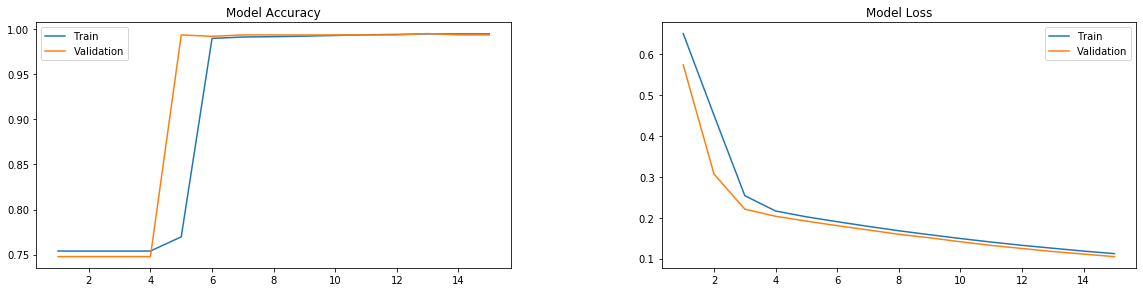

In [27]:
model_plots(model_1_logs)

We'll build another fully connected neural network, increasing the learning rate to `0.01` (2x the rate of model 1).

In [28]:
model_2, model_2_logs = ann_binary(X_train = X_train_featurized,
                                   y_train = y_train,
                                   X_test = X_valid_featurized,
                                   y_test = y_valid,
                                   epochs = 15,
                                   batch_size = 256,
                                   learning_rate = 0.01,
                                   hidden_layers = [8, 4, 2]
                                  )

Epoch 1/15
21/21 [==============================] - 0s 6ms/step - loss: 0.6704 - accuracy: 0.7389 - val_loss: 0.6473 - val_accuracy: 0.7477
Epoch 2/15
21/21 [==============================] - 0s 2ms/step - loss: 0.6289 - accuracy: 0.7539 - val_loss: 0.6145 - val_accuracy: 0.7477
Epoch 3/15
21/21 [==============================] - 0s 3ms/step - loss: 0.6008 - accuracy: 0.7539 - val_loss: 0.5928 - val_accuracy: 0.7477
Epoch 4/15
21/21 [==============================] - 0s 2ms/step - loss: 0.5824 - accuracy: 0.7539 - val_loss: 0.5800 - val_accuracy: 0.7477
Epoch 5/15
21/21 [==============================] - 0s 1ms/step - loss: 0.5716 - accuracy: 0.7539 - val_loss: 0.5724 - val_accuracy: 0.7477
Epoch 6/15
21/21 [==============================] - 0s 2ms/step - loss: 0.5652 - accuracy: 0.7539 - val_loss: 0.5683 - val_accuracy: 0.7477
Epoch 7/15
21/21 [==============================] - 0s 2ms/step - loss: 0.5615 - accuracy: 0.7539 - val_loss: 0.5663 - val_accuracy: 0.7477
Epoch 8/15
21/21 [==

**Model 2**
- `epochs = 15`
- `batch_size = 256`
- `learning_rate = 0.01`
- `hidden_layers = [8, 4, 2]`

Increasing the learning rate really seemed to hurt our model.  Even though the loss is decreasing until around epoch 6-8, our accuracy is stuck at \~75% from the start.  Model loss of \~0.55 is noticeably higher than in our first model (\~0.1).


 Validation Accuracy: 0.748 
 Validation Loss: 0.565


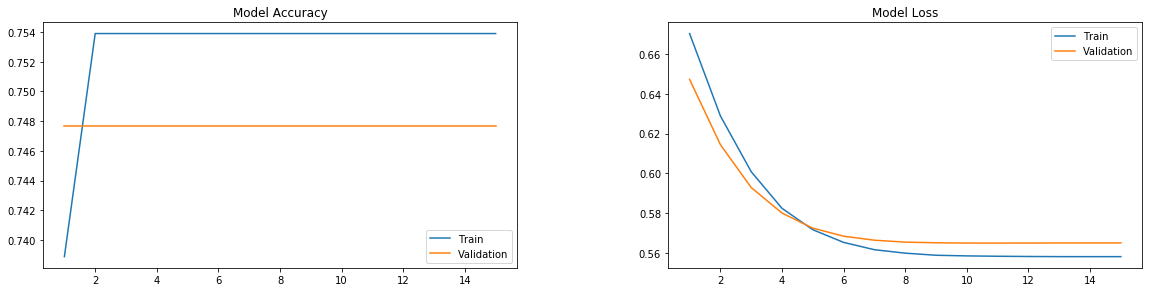

In [29]:
model_plots(model_2_logs)

Since neural networks may have difficulty converging if we get unlucky with the random initilization of our weights, let's try building this model again, using the exact same hyper parameters.

The only difference between this model and model 2 will be the random initilization of our weights.

At this point, we'll turn off verbosity for brevity sake.

In [30]:
model_3, model_3_logs = ann_binary(X_train = X_train_featurized,
                                   y_train = y_train,
                                   X_test = X_valid_featurized,
                                   y_test = y_valid,
                                   epochs = 15,
                                   batch_size = 256,
                                   learning_rate = 0.01,
                                   hidden_layers = [8, 4, 2],
                                   verbose = 0
                                  )

**Model 3**
- `epochs = 15`
- `batch_size = 256`
- `learning_rate = 0.01`
- `hidden_layers = [8, 4, 2]`

Interestingly, even though our hyper parameters were identical, it looks like our model *was* able to converge in this case.

Around epoch 4-5, the model accuracy jumps up from 75% to 99%+, similiary to model 1.

So what gives?  The random initialization of our weights appears to make a big difference in our model's performance.  To address this, we'll try adding some regularization to our next model.


 Validation Accuracy: 0.998 
 Validation Loss: 0.061


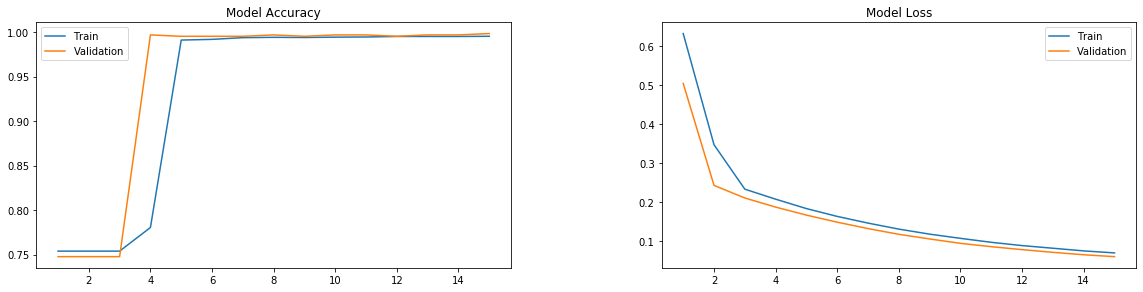

In [31]:
model_plots(model_3_logs)

In this model, we'll make a few changes.  We'll increase epochs to 25 to give a bit more training time, add an additional hidden layer, and lower our learning rate back to 0.005.  Lastly, we'll also add dropout to increase our model regularization.

Using a dropout rate of 20% will randomly remove 20% of our neural nodes (i.e.: set their weight values to 0).  This forces the model to not become overly reliant on any particular layer(s) when training.

In [32]:
model_4, model_4_logs = ann_binary(X_train = X_train_featurized,
                                   y_train = y_train,
                                   X_test = X_valid_featurized,
                                   y_test = y_valid,
                                   epochs = 15,
                                   batch_size = 256,
                                   learning_rate = 0.005,
                                   hidden_layers = [16, 8, 6, 4],
                                   dropout = 0.2,
                                   verbose = 0
                                  )

This model is also quite accurate (99%+) and with our regularization, we do see more of a gap between training and validation loss (and we actually get a new "best" loss of `0.020`).


 Validation Accuracy: 0.995 
 Validation Loss: 0.02


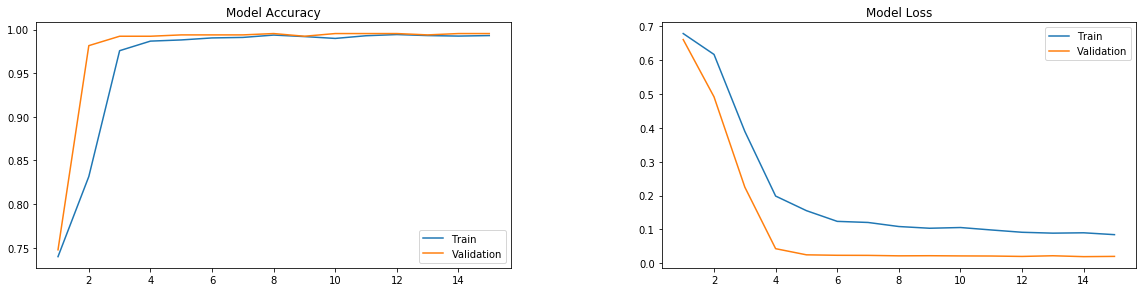

In [33]:
model_plots(model_4_logs)

In our next model, we'll try reducing the batch size.  We'll try 16 observations at a time and see how that affects training.

In [34]:
model_5, model_5_logs = ann_binary(X_train = X_train_featurized,
                                   y_train = y_train,
                                   X_test = X_valid_featurized,
                                   y_test = y_valid,
                                   epochs = 15,
                                   batch_size = 16,
                                   learning_rate = 0.005,
                                   hidden_layers = [16, 8, 6, 4],
                                   dropout = 0.2,
                                   verbose = 0
                                  )

With a smaller batch, compute time went up a bit, but it still looks like are model performed well (even slightly better than our last model, \#4). 

In this model, we see a gap between train and validation for both model loss **and** model accuracy (with validation performing slightly better on both metrics).


 Validation Accuracy: 0.997 
 Validation Loss: 0.015


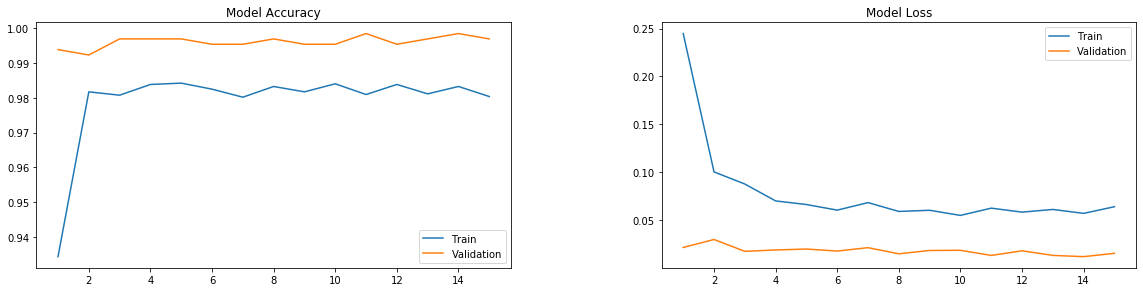

In [35]:
model_plots(model_5_logs)

Up until now, we've made some slight tweaks to our learning rate. Now let's see how the models perofrms if we increase the learning rate significantly - up 0.05 (10x most of our models above).

In [36]:
model_6, model_6_logs = ann_binary(X_train = X_train_featurized,
                                   y_train = y_train,
                                   X_test = X_valid_featurized,
                                   y_test = y_valid,
                                   epochs = 15,
                                   batch_size = 16,
                                   learning_rate = 0.05,
                                   hidden_layers = [16, 8, 6, 4],
                                   dropout = 0.2,
                                   verbose = 0
                                  )

While the validation loss and accuracy drops slightly, we see that the training set performance drops pretty noticeably.  We also see pretty high variance as we progress through each epoch, indicating this learning rate is probably too high.


 Validation Accuracy: 0.978 
 Validation Loss: 0.095


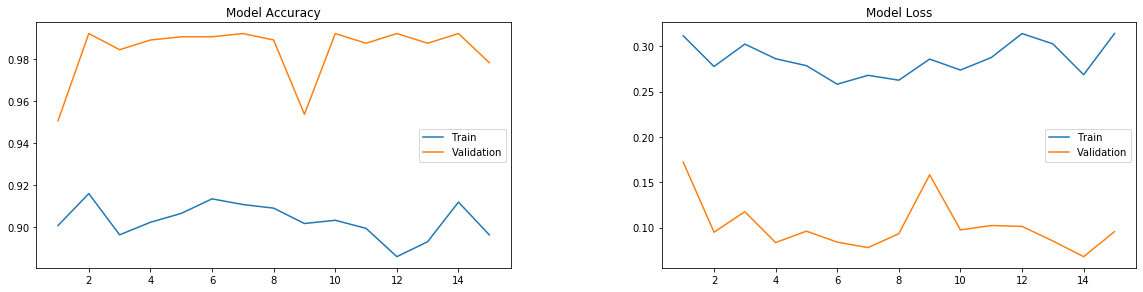

In [37]:
model_plots(model_6_logs)

### Evaluating on a nice set of hyper parameters

Model 5 above has the best accuracy and loss on our validation set.  We'll evaluate that model on the *test set* (swapping out the validation set).

First, let's set hyper parameters from our best model.

In [38]:
# set winning model params
epochs = 15
batch_size = 16
learning_rate = 0.005
hidden_layers = [16, 8, 6, 4]
dropout = 0.2
verbose = 0

And now we'll initialize and fit the model against the **test set**.

In [39]:
best_model, best_model_logs = ann_binary(X_train = X_train_featurized,
                                         y_train = y_train,
                                         X_test = X_test_featurized,
                                         y_test = y_test,
                                         epochs = epochs,
                                         batch_size = batch_size,
                                         learning_rate = learning_rate,
                                         hidden_layers = hidden_layers,
                                         dropout = dropout,
                                         verbose = verbose
                                        )

And we see that model accuracy on the test set is just as good as it was on the validation set (`99.7%`) with a low loss as well (`0.026`).


 Test Accuracy: 0.997 
 Test Loss: 0.126


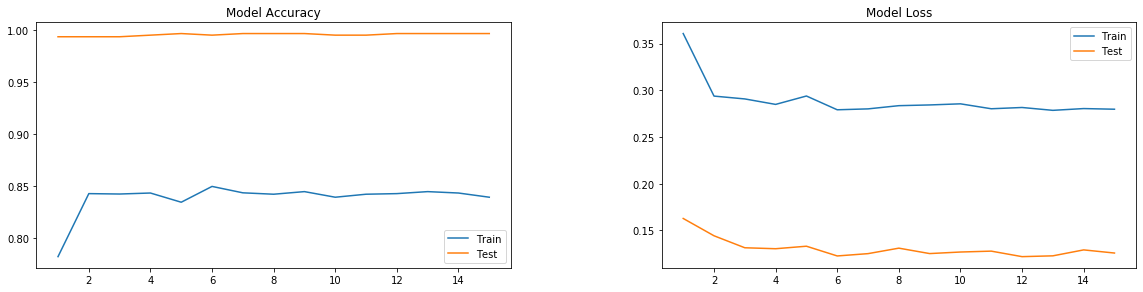

In [40]:
model_plots(best_model_logs, 'Test')

Let's compare hard predictions by class. By rounding the probabilities, we essentially predict 1 ('red') if P(red) >= 0.5, and white otherwise.

In [41]:
y_test_hat = np.round(best_model.predict(X_test_featurized))

For further evaluation on Test set, we'll define functions to clearly present the following:

- accuracy metrics (f1, precision, recall, etc)
- confusion matrix

In [42]:
def accuracy_report(y, y_hat):
    # store accuracy metrics (f1, precision, recall, accuracy, + full report)
    f1 = f1_score(y, y_hat, pos_label = 1)
    precision = precision_score(y, y_hat, pos_label = 1)
    recall = recall_score(y, y_hat, pos_label = 1)
    accuracy = accuracy_score(y, y_hat)
    class_rpt = classification_report(y, y_hat, zero_division = 0)
    
    # print accuracy measures
    print("f1: ", round(f1, 4))
    print("precision: ", round(precision, 4))
    print("recall: ", round(recall, 4))
    print("accuracy: ", round(accuracy, 4))
    print("==================================")
    print(class_rpt)

In [43]:
def format_cm(y, y_hat, title, labels, norm):
    ''' norm = { 'true', 'pred', 'all', None }'''
    
    # store (normalized) confusion matrix
    cm = np.round(confusion_matrix(y, y_hat, normalize = norm), 3)

    # configure confusion matrix plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # show plot and confusion matrix
    plt.show()
    print(cm)

Based on the accuracy metrics, it looks like (within rounding) every single red wine was identified by our neural network (`positive recall = 1.000`).

As we saw from the training progress, overall accuracy was 99.7%.

In [44]:
# accuracy metrics
accuracy_report(y_test, y_test_hat)

f1:  0.9936
precision:  0.9873
recall:  1.0
accuracy:  0.9969
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       494
           1       0.99      1.00      0.99       156

    accuracy                           1.00       650
   macro avg       0.99      1.00      1.00       650
weighted avg       1.00      1.00      1.00       650



And from the confusion matrix, we can more easily see that we had 2 misclassifications.  Both were a prediction of red wine that was actually white wine (false positives).

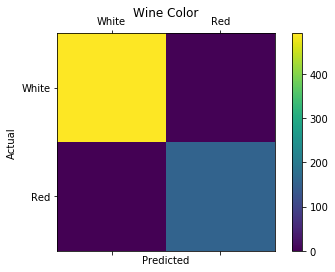

[[492   2]
 [  0 156]]


In [45]:
# confusion matrix
format_cm(y_test, y_test_hat, "Wine Color", ["White", "Red"], None)

## Summary

In summary, we were able to correctly classify wine (red, white) in 99.7% of cases.  Our model was extremely accurate - on both classes.

To the extent that we can extrapolate our two misclassifications, we'd say the model is slightly more precise for white wines, but with slightly better recall on red wines.  Realistically, though - this model performed equally on both classes.

With that in mind, there shouldn't be much (if any) seasonal bias in our model accuracy (assuming certain wines are more likely to be consumed at certain times in the year).